# Chunking Analysis for LangGraph Helper Agent

This notebook analyzes the filtered documentation corpus to determine optimal chunking strategy for RAG.

**Data Sources:**
- `langgraph-llms-full.txt` - Dedicated LangGraph Python docs (all included)
- `langchain-llms-full.txt` - Filtered to Python LangChain, integrations, migrations, releases


In [3]:
import os
import re
from pathlib import Path
from dataclasses import dataclass
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import google.genai as genai

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

DATA_DIR = Path("../data")
OUTPUT_DIR = DATA_DIR / "processed"
OUTPUT_DIR.mkdir(exist_ok=True)


In [4]:
# Configure Gemini
api_key = os.getenv("GOOGLE_API_KEY") or os.getenv("GEMINI_API_KEY")
if api_key:
    client = genai.Client(api_key=api_key)
    print("✓ Gemini API configured")
else:
    client = None
    print("⚠ No API key found. Set GOOGLE_API_KEY or GEMINI_API_KEY")


✓ Gemini API configured


## 1. Document Parsing

Parse both documentation files with their respective formats.


In [5]:
@dataclass
class Document:
    """Parsed document from llms.txt files."""
    title: str
    source: str  # file path or URL
    content: str
    source_file: str  # which llms.txt file it came from
    category: str = ""  # extracted category for filtering
    
    @property
    def char_count(self) -> int:
        return len(self.content)
    
    @property
    def word_count(self) -> int:
        return len(self.content.split())
    
    def __repr__(self):
        return f"Document(title='{self.title[:40]}...', chars={self.char_count})"


In [6]:
def parse_langgraph_file(filepath: Path) -> list[Document]:
    """
    Parse LangGraph llms-full.txt format.
    Format: ---\npath.md\n---\n# Title\ncontent\n---\n...
    """
    content = filepath.read_text(encoding="utf-8")
    
    # Split by document delimiter pattern: ---\nfilepath.md\n---
    pattern = r"^---\n([\w\-/]+\.(?:md|ipynb))\n---\n"
    
    docs = []
    parts = re.split(pattern, content, flags=re.MULTILINE)
    
    # parts[0] is empty or preamble, then alternating: path, content, path, content...
    for i in range(1, len(parts), 2):
        if i + 1 >= len(parts):
            break
            
        path = parts[i].strip()
        doc_content = parts[i + 1].strip()
        
        # Extract title from first # heading
        title_match = re.search(r"^#\s+(.+)$", doc_content, re.MULTILINE)
        title = title_match.group(1) if title_match else path
        
        # Extract category from path (e.g., "how-tos", "concepts")
        category = path.split("/")[0] if "/" in path else "root"
        
        docs.append(Document(
            title=title,
            source=path,
            content=doc_content,
            source_file="langgraph",
            category=category
        ))
    
    return docs


def parse_langchain_file(filepath: Path) -> list[Document]:
    """
    Parse LangChain llms-full.txt format.
    Format: # Title\nSource: url\n\ncontent\n\n***\n\n...
    """
    content = filepath.read_text(encoding="utf-8")
    
    # Split by title pattern (# at start of line, followed by Source:)
    pattern = r"^(# .+?)\nSource: (https?://[^\n]+)\n"
    
    docs = []
    matches = list(re.finditer(pattern, content, re.MULTILINE))
    
    for i, match in enumerate(matches):
        title = match.group(1).lstrip("# ").strip()
        source = match.group(2).strip()
        
        # Content is from end of this match to start of next (or end of file)
        start = match.end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(content)
        doc_content = content[start:end].strip()
        
        # Clean up trailing separators
        doc_content = re.sub(r"\n\*{3}\s*$", "", doc_content)
        
        # Extract category from URL path
        category = extract_langchain_category(source)
        
        docs.append(Document(
            title=title,
            source=source,
            content=doc_content,
            source_file="langchain",
            category=category
        ))
    
    return docs


def extract_langchain_category(url: str) -> str:
    """Extract category from langchain URL for filtering."""
    if "/oss/python/langchain/" in url:
        return "oss/python/langchain"
    elif "/oss/python/langgraph/" in url:
        return "oss/python/langgraph"
    elif "/oss/python/integrations/" in url:
        return "oss/python/integrations"
    elif "/oss/python/migrate/" in url:
        return "oss/python/migrate"
    elif "/oss/python/releases/" in url:
        return "oss/python/releases"
    elif "/oss/python/deepagents/" in url:
        return "oss/python/deepagents"
    elif "/oss/python/contributing/" in url:
        return "oss/python/contributing"
    elif "/oss/python/concepts/" in url:
        return "oss/python/concepts"
    elif "/oss/python/" in url:
        return "oss/python/other"
    elif "/oss/javascript/" in url:
        return "oss/javascript"
    elif "/langsmith/" in url:
        return "langsmith"
    else:
        return "other"


In [7]:
# Parse both files
print("Parsing LangGraph docs...")
langgraph_docs = parse_langgraph_file(DATA_DIR / "langgraph-llms-full.txt")
print(f"  Found {len(langgraph_docs)} documents")

print("\nParsing LangChain docs...")
langchain_docs_all = parse_langchain_file(DATA_DIR / "langchain-llms-full.txt")
print(f"  Found {len(langchain_docs_all)} documents")

# Show category breakdown before filtering
print("\nLangChain categories (before filtering):")
category_counts = Counter(d.category for d in langchain_docs_all)
for cat, count in category_counts.most_common():
    print(f"  {cat}: {count}")


Parsing LangGraph docs...
  Found 59 documents

Parsing LangChain docs...
  Found 575 documents

LangChain categories (before filtering):
  langsmith: 329
  oss/javascript: 126
  oss/python/langchain: 34
  oss/python/langgraph: 28
  oss/python/integrations: 18
  oss/python/contributing: 12
  oss/python/other: 10
  oss/python/deepagents: 10
  oss/python/releases: 3
  oss/python/concepts: 2
  oss/python/migrate: 2
  other: 1


## 2. Data Filtering

Apply filtering to keep only relevant documentation:
- **Keep:** `/oss/python/langchain/`, `/oss/python/integrations/`, `/oss/python/migrate/`, `/oss/python/releases/`
- **Exclude:** JavaScript, LangSmith, deepagents, contributing, concepts, and duplicate LangGraph docs


In [8]:
KEEP_CATEGORIES = {
    "oss/python/langchain",
    "oss/python/integrations", 
    "oss/python/migrate",
    "oss/python/releases",
}

langchain_docs_filtered = [
    doc for doc in langchain_docs_all 
    if doc.category in KEEP_CATEGORIES
]

print("=== Filtering Results ===")
print(f"\nLangChain docs: {len(langchain_docs_all)} -> {len(langchain_docs_filtered)} (kept {len(langchain_docs_filtered)/len(langchain_docs_all)*100:.1f}%)")

# Show what we kept
print("\nKept categories:")
kept_counts = Counter(d.category for d in langchain_docs_filtered)
for cat, count in kept_counts.most_common():
    print(f"  {cat}: {count}")

# Show what we excluded
excluded_counts = Counter(d.category for d in langchain_docs_all if d.category not in KEEP_CATEGORIES)
print("\nExcluded categories:")
for cat, count in excluded_counts.most_common():
    print(f"  {cat}: {count}")


=== Filtering Results ===

LangChain docs: 575 -> 57 (kept 9.9%)

Kept categories:
  oss/python/langchain: 34
  oss/python/integrations: 18
  oss/python/releases: 3
  oss/python/migrate: 2

Excluded categories:
  langsmith: 329
  oss/javascript: 126
  oss/python/langgraph: 28
  oss/python/contributing: 12
  oss/python/other: 10
  oss/python/deepagents: 10
  oss/python/concepts: 2
  other: 1


In [9]:
all_docs = langgraph_docs + langchain_docs_filtered

print(f"=== Final Corpus ===")
print(f"LangGraph (dedicated): {len(langgraph_docs)} docs")
print(f"LangChain (filtered):  {len(langchain_docs_filtered)} docs")
print(f"Total:                 {len(all_docs)} docs")


=== Final Corpus ===
LangGraph (dedicated): 59 docs
LangChain (filtered):  57 docs
Total:                 116 docs


## 3. Basic Statistics

Analyze document sizes and token counts for the filtered corpus.


In [10]:
def docs_to_df(docs: list[Document]) -> pd.DataFrame:
    """Convert documents to DataFrame for analysis."""
    return pd.DataFrame([
        {
            "title": d.title,
            "source": d.source,
            "source_file": d.source_file,
            "category": d.category,
            "char_count": d.char_count,
            "word_count": d.word_count,
            "content": d.content,
        }
        for d in docs
    ])

df = docs_to_df(all_docs)

print("=== Document Size Statistics ===")
print(f"\nTotal documents: {len(df)}")
print(f"\nBy source file:")
print(df.groupby("source_file").size())
print(f"\nCharacter count stats:")
print(df["char_count"].describe().round(0))


=== Document Size Statistics ===

Total documents: 116

By source file:
source_file
langchain    57
langgraph    59
dtype: int64

Character count stats:
count      116.0
mean     14385.0
std      14315.0
min        352.0
25%       3510.0
50%       8788.0
75%      21766.0
max      66839.0
Name: char_count, dtype: float64


In [11]:
# Token counting with Gemini
def count_tokens_gemini(text: str, model_name: str = "gemini-2.0-flash") -> int:
    """Count tokens using Gemini API."""
    response = client.models.count_tokens(
        model=model_name,
        contents=text
    )
    return response.total_tokens


def count_tokens_batch(docs: list[Document], model_name: str = "gemini-2.0-flash") -> list[int]:
    """Count tokens for a batch of documents with progress bar."""
    token_counts = []
    for doc in tqdm(docs, desc="Counting tokens"):
        try:
            count = count_tokens_gemini(doc.content, model_name)
            token_counts.append(count)
        except Exception as e:
            print(f"Error counting tokens for '{doc.title[:30]}': {e}")
            # Fallback: rough estimate (4 chars per token)
            token_counts.append(doc.char_count // 4)
    return token_counts


In [12]:
# Count tokens for filtered corpus
print(f"Counting tokens for {len(all_docs)} documents...")
token_counts = count_tokens_batch(all_docs)
df["token_count"] = token_counts

print("\n=== Token Count Statistics ===")
print(df["token_count"].describe().round(0))
print(f"\nTotal tokens in corpus: {df['token_count'].sum():,}")


Counting tokens for 116 documents...


Counting tokens:   0%|          | 0/116 [00:00<?, ?it/s]


=== Token Count Statistics ===
count      116.0
mean      3801.0
std       3899.0
min        109.0
25%        899.0
50%       2451.0
75%       5683.0
max      18407.0
Name: token_count, dtype: float64

Total tokens in corpus: 440,873


In [13]:
# Token statistics by source
print("=== Token Stats by Source ===")
print(df.groupby("source_file")["token_count"].agg(["count", "sum", "mean", "median", "max"]).round(0))

print("\n=== Token Stats by Category ===")
print(df.groupby("category")["token_count"].agg(["count", "sum", "mean", "max"]).round(0))


=== Token Stats by Source ===
             count     sum    mean  median    max
source_file                                      
langchain       57  279423  4902.0  3767.0  16357
langgraph       59  161450  2736.0  1576.0  18407

=== Token Stats by Category ===
                         count     sum    mean    max
category                                             
concepts                    38   67149  1767.0   7862
how-tos                     21   94301  4491.0  18407
oss/python/integrations     18   98692  5483.0  16357
oss/python/langchain        34  160944  4734.0  16219
oss/python/migrate           2   11797  5898.0  10587
oss/python/releases          3    7990  2663.0   6282


/var/folders/g9/5mxlzjpn6r36lyhl91c1cthr0000gn/T/ipykernel_36798/3559783323.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="source_file", y="token_count", ax=axes[1], palette=["#2ecc71", "#3498db"])


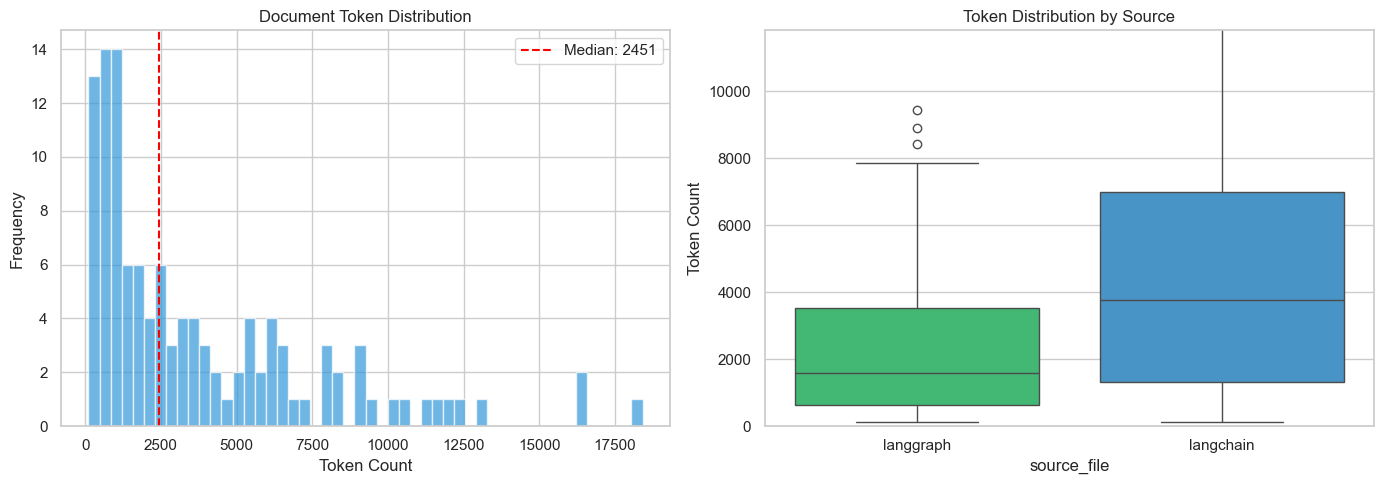

In [14]:
# Visualize token distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
df["token_count"].hist(bins=50, ax=axes[0], color="#3498db", alpha=0.7, edgecolor="white")
axes[0].set_xlabel("Token Count")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Document Token Distribution")
axes[0].axvline(x=df["token_count"].median(), color="red", linestyle="--", label=f"Median: {df['token_count'].median():.0f}")
axes[0].legend()

# Box plot by source
sns.boxplot(data=df, x="source_file", y="token_count", ax=axes[1], palette=["#2ecc71", "#3498db"])
axes[1].set_ylabel("Token Count")
axes[1].set_title("Token Distribution by Source")
axes[1].set_ylim(0, df["token_count"].quantile(0.95))  # Cap at 95th percentile for visibility

plt.tight_layout()
plt.show()


## 4. Code Block Analysis

Analyze code blocks in documents - important for chunking decisions since code blocks should ideally stay together.


In [15]:
def analyze_code_blocks(content: str) -> dict:
    """Extract code block statistics from markdown content."""
    # Find all code blocks (```...```)
    code_blocks = re.findall(r"```[\w]*\n(.*?)```", content, re.DOTALL)
    
    if not code_blocks:
        return {
            "code_block_count": 0,
            "total_code_chars": 0,
            "code_ratio": 0.0,
            "max_block_size": 0,
            "avg_block_size": 0.0,
        }
    
    block_sizes = [len(b) for b in code_blocks]
    total_code = sum(block_sizes)
    
    return {
        "code_block_count": len(code_blocks),
        "total_code_chars": total_code,
        "code_ratio": total_code / len(content) if content else 0,
        "max_block_size": max(block_sizes),
        "avg_block_size": np.mean(block_sizes),
    }

# Analyze all documents
print("Analyzing code blocks...")
code_stats = df["content"].apply(analyze_code_blocks).apply(pd.Series)
df = pd.concat([df, code_stats], axis=1)

print("=== Code Block Statistics ===")
print(f"\nDocuments with code: {(df['code_block_count'] > 0).sum()} / {len(df)} ({(df['code_block_count'] > 0).mean()*100:.1f}%)")
print(f"\nCode ratio (code chars / total chars):")
print(df["code_ratio"].describe().round(3))


Analyzing code blocks...
=== Code Block Statistics ===

Documents with code: 81 / 116 (69.8%)

Code ratio (code chars / total chars):
count    116.000
mean       0.228
std        0.224
min        0.000
25%        0.000
50%        0.185
75%        0.391
max        0.772
Name: code_ratio, dtype: float64


In [16]:
# Code block statistics by source
print("=== Code Stats by Source ===")
print(df.groupby("source_file")[["code_block_count", "code_ratio", "max_block_size"]].mean().round(2))

# Identify documents with large code blocks (potential chunking issues)
large_code_threshold = 2000  # chars
docs_with_large_blocks = df[df["max_block_size"] > large_code_threshold]
print(f"\n=== Documents with Large Code Blocks (>{large_code_threshold} chars) ===")
print(f"Count: {len(docs_with_large_blocks)} documents")
if len(docs_with_large_blocks) > 0:
    print("\nTop 10 by max block size:")
    print(docs_with_large_blocks.nlargest(10, "max_block_size")[["title", "source_file", "max_block_size", "code_block_count"]])


=== Code Stats by Source ===
             code_block_count  code_ratio  max_block_size
source_file                                              
langchain               15.35        0.24         1370.95
langgraph                8.95        0.22          836.92

=== Documents with Large Code Blocks (>2000 chars) ===
Count: 23 documents

Top 10 by max block size:
                                                 title source_file  \
74                                    Embedding models   langchain   
112                       LangGraph v1 migration guide   langchain   
89                                            Messages   langchain   
111                       LangChain v1 migration guide   langchain   
114                         What's new in LangChain v1   langchain   
12   How to add multi-turn conversation in a multi-...   langgraph   
90                                 Built-in middleware   langchain   
99                    Build a RAG agent with LangChain   langchain   
11   H

## 5. Header Structure Analysis

Analyze markdown header structure to identify natural split points for hierarchical chunking.


In [18]:
def analyze_headers(content: str) -> dict:
    """Analyze markdown header structure."""
    headers = re.findall(r"^(#{1,6})\s+(.+)$", content, re.MULTILINE)
    
    if not headers:
        return {"h1": 0, "h2": 0, "h3": 0, "h4": 0, "h5": 0, "h6": 0, "total_headers": 0, "max_depth": 0}
    
    counts = Counter(len(h[0]) for h in headers)
    
    return {
        "h1": counts.get(1, 0),
        "h2": counts.get(2, 0),
        "h3": counts.get(3, 0),
        "h4": counts.get(4, 0),
        "h5": counts.get(5, 0),
        "h6": counts.get(6, 0),
        "total_headers": len(headers),
        "max_depth": max(len(h[0]) for h in headers),
    }

# Analyze headers
print("Analyzing header structure...")
header_stats = df["content"].apply(analyze_headers).apply(pd.Series)
df = pd.concat([df, header_stats], axis=1)

print("=== Header Structure Statistics ===")
print(df[["h1", "h2", "h3", "h4", "total_headers", "max_depth"]].describe().round(2))


Analyzing header structure...
=== Header Structure Statistics ===
           h1      h2      h3      h4  total_headers  max_depth
count  116.00  116.00  116.00  116.00         116.00     116.00
mean     3.26    4.07    4.16    0.75          12.31       2.67
std      5.32    2.83    6.25    2.00          12.08       0.94
min      0.00    0.00    0.00    0.00           0.00       0.00
25%      0.00    2.00    0.00    0.00           4.00       2.00
50%      1.00    3.50    2.00    0.00           8.00       3.00
75%      4.00    5.00    6.00    0.00          17.00       3.00
max     32.00   14.00   35.00   12.00          61.00       5.00


In [26]:
header_stats

,h1,h2,h3,h4,h5,h6,total_headers,max_depth
0,12,4,4,0,0,0,20,3
1,5,7,0,0,0,0,12,2
2,1,1,0,0,0,0,2,2
3,32,12,14,1,0,0,59,4
4,1,3,15,2,0,0,21,4
...,...,...,...,...,...,...,...,...
111,7,6,27,12,0,0,52,4
112,0,4,1,0,0,0,5,3
113,0,0,0,0,0,0,0,0
114,6,7,6,2,0,0,21,4


In [19]:
# Header statistics by source
print("=== Average Headers by Source ===")
print(df.groupby("source_file")[["h1", "h2", "h3", "h4", "total_headers", "max_depth"]].mean().round(2))

# Most common header structure
print("\n=== Header Depth Distribution ===")
print(df["max_depth"].value_counts().sort_index())


=== Average Headers by Source ===
               h1    h2    h3    h4  total_headers  max_depth
source_file                                                  
langchain    2.28  4.16  5.40  0.93          12.88       2.72
langgraph    4.20  3.98  2.97  0.58          11.76       2.63

=== Header Depth Distribution ===
max_depth
0     3
1     3
2    47
3    41
4    20
5     2
Name: count, dtype: int64


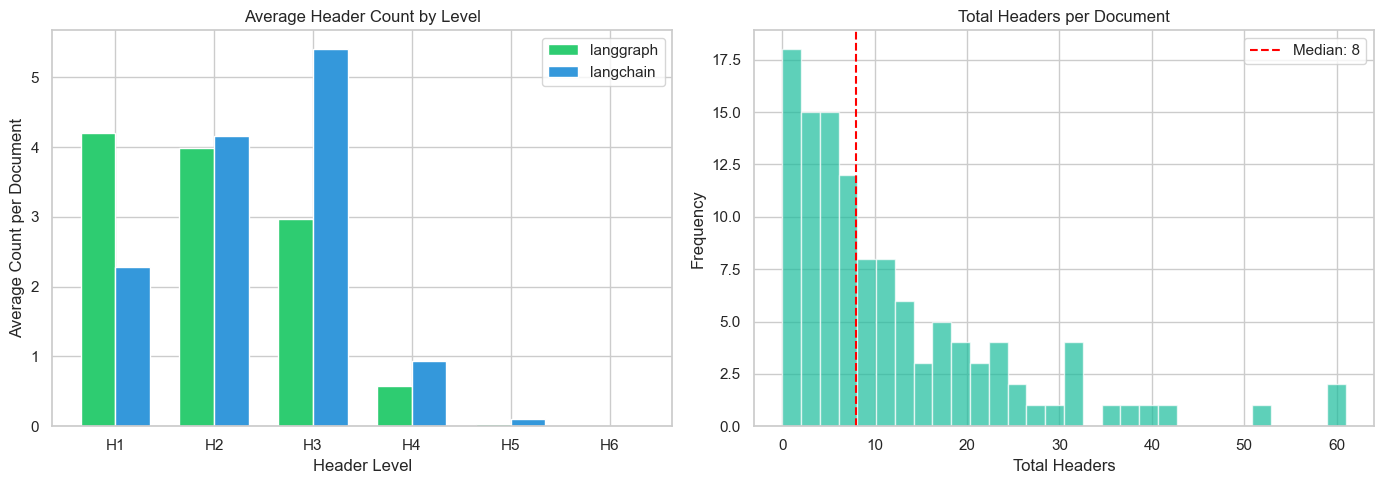

In [20]:
# Visualize header structure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average headers by level
header_cols = ["h1", "h2", "h3", "h4", "h5", "h6"]
x = np.arange(len(header_cols))
width = 0.35

lg_means = df[df["source_file"] == "langgraph"][header_cols].mean()
lc_means = df[df["source_file"] == "langchain"][header_cols].mean()

axes[0].bar(x - width/2, lg_means, width, label="langgraph", color="#2ecc71")
axes[0].bar(x + width/2, lc_means, width, label="langchain", color="#3498db")
axes[0].set_xlabel("Header Level")
axes[0].set_ylabel("Average Count per Document")
axes[0].set_title("Average Header Count by Level")
axes[0].set_xticks(x)
axes[0].set_xticklabels(["H1", "H2", "H3", "H4", "H5", "H6"])
axes[0].legend()

# Total headers distribution
df["total_headers"].hist(bins=30, ax=axes[1], color="#1abc9c", alpha=0.7, edgecolor="white")
axes[1].set_xlabel("Total Headers")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Total Headers per Document")
axes[1].axvline(x=df["total_headers"].median(), color="red", linestyle="--", label=f"Median: {df['total_headers'].median():.0f}")
axes[1].legend()

plt.tight_layout()
plt.show()


In [21]:
# Analyze potential split points (H2 headers are typically good split points)
print("=== H2 as Split Point Analysis ===")
print(f"\nDocuments with H2 headers: {(df['h2'] > 0).sum()} / {len(df)} ({(df['h2'] > 0).mean()*100:.1f}%)")
print(f"\nAverage H2 headers per document: {df['h2'].mean():.1f}")
print(f"\nIf splitting by H2, estimated chunks: {df['h2'].sum() + len(df):.0f}")  # Each doc starts with 1 chunk, then splits at H2


=== H2 as Split Point Analysis ===

Documents with H2 headers: 109 / 116 (94.0%)

Average H2 headers per document: 4.1

If splitting by H2, estimated chunks: 588


## 6. Chunking Strategy Recommendations

Based on the analysis, determine optimal chunk size and strategy.


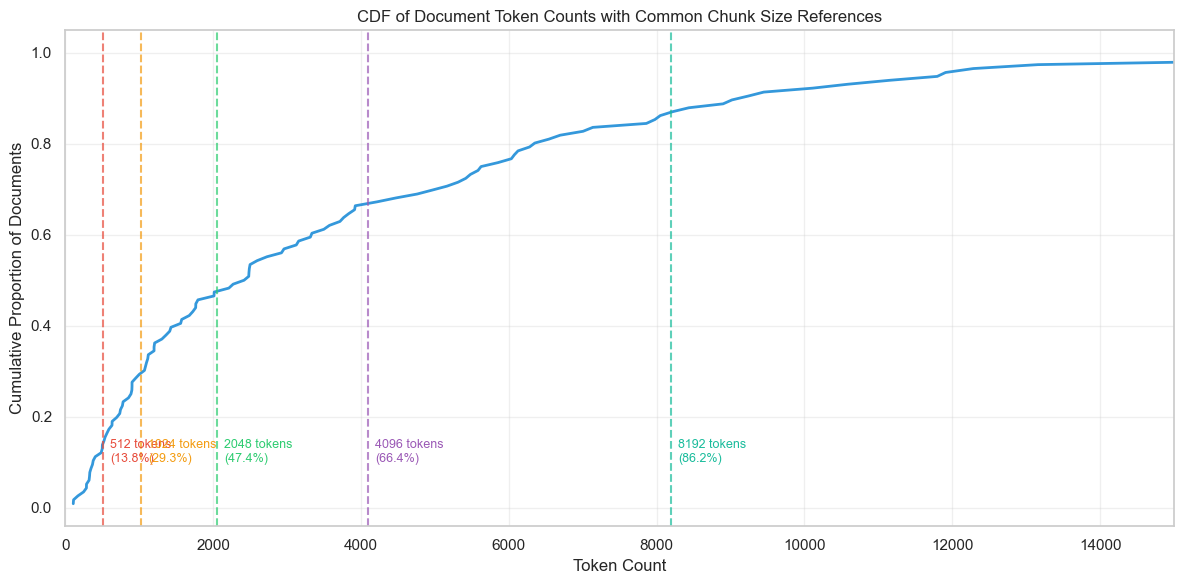

In [22]:
# CDF analysis for chunk size decisions
fig, ax = plt.subplots(figsize=(12, 6))

# Sort and compute CDF
sorted_tokens = df["token_count"].sort_values()
cdf = np.arange(1, len(sorted_tokens) + 1) / len(sorted_tokens)

ax.plot(sorted_tokens, cdf, linewidth=2, color="#3498db")

# Add reference lines for common chunk sizes
chunk_sizes = [512, 1024, 2048, 4096, 8192]
colors = ["#e74c3c", "#f39c12", "#2ecc71", "#9b59b6", "#1abc9c"]

for size, color in zip(chunk_sizes, colors):
    pct = (df["token_count"] <= size).mean() * 100
    ax.axvline(x=size, color=color, linestyle="--", alpha=0.7)
    ax.text(size + 100, 0.1, f"{size} tokens\n({pct:.1f}%)", fontsize=9, color=color)

ax.set_xlabel("Token Count")
ax.set_ylabel("Cumulative Proportion of Documents")
ax.set_title("CDF of Document Token Counts with Common Chunk Size References")
ax.set_xlim(0, 15000)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [23]:
# Chunk size coverage analysis
print("=== Chunk Size Coverage Analysis ===")
print("\nWhat percentage of documents fit within each chunk size?")
for size in [512, 1024, 2048, 4096, 8192, 16384]:
    pct = (df["token_count"] <= size).mean() * 100
    print(f"  {size:>6} tokens: {pct:>5.1f}% of documents")

print("\n=== Documents Exceeding Common Chunk Sizes ===")
for size in [2048, 4096, 8192]:
    exceeding = df[df["token_count"] > size]
    print(f"\n>{size} tokens: {len(exceeding)} documents")
    if len(exceeding) > 0 and len(exceeding) <= 10:
        for _, row in exceeding.iterrows():
            print(f"  - {row['title'][:50]}... ({row['token_count']} tokens)")


=== Chunk Size Coverage Analysis ===

What percentage of documents fit within each chunk size?
     512 tokens:  13.8% of documents
    1024 tokens:  29.3% of documents
    2048 tokens:  47.4% of documents
    4096 tokens:  66.4% of documents
    8192 tokens:  86.2% of documents
   16384 tokens:  99.1% of documents

=== Documents Exceeding Common Chunk Sizes ===

>2048 tokens: 61 documents

>4096 tokens: 39 documents

>8192 tokens: 16 documents


In [28]:

no_h2 = df[df["h2"] == 0]
print(f"=== Documents WITHOUT H2 Headers: {len(no_h2)} ===\n")

for _, row in no_h2.iterrows():
    print(f"- {row['title'][:60]}")
    print(f"  Source: {row['source_file']} | Category: {row['category']}")
    print(f"  Tokens: {row['token_count']:,} | Headers: H1={row['h1']}, H3={row['h3']}, H4={row['h4']}")
    print()

=== Documents WITHOUT H2 Headers: 7 ===

- Subgraphs
  Source: langgraph | Category: concepts
  Tokens: 904 | Headers: H1=1, H3=0, H4=0

- MCP
  Source: langgraph | Category: concepts
  Tokens: 109 | Headers: H1=1, H3=0, H4=0

- Time Travel ⏱️
  Source: langgraph | Category: concepts
  Tokens: 248 | Headers: H1=1, H3=0, H4=0

- LangChain Academy
  Source: langchain | Category: oss/python/langchain
  Tokens: 113 | Headers: H1=0, H3=0, H4=0

- Install LangChain
  Source: langchain | Category: oss/python/langchain
  Tokens: 349 | Headers: H1=0, H3=0, H4=0

- Agent Chat UI
  Source: langchain | Category: oss/python/langchain
  Tokens: 890 | Headers: H1=0, H3=3, H4=0

- Changelog
  Source: langchain | Category: oss/python/releases
  Tokens: 591 | Headers: H1=0, H3=0, H4=0



## 7. Export Filtered Dataset

Save the filtered and analyzed documents for use in the RAG pipeline.


In [29]:
import json

# Prepare documents for export
docs_for_export = []
for _, row in df.iterrows():
    docs_for_export.append({
        "title": row["title"],
        "source": row["source"],
        "source_file": row["source_file"],
        "category": row["category"],
        "content": row["content"],
        "token_count": int(row["token_count"]),
        "char_count": int(row["char_count"]),
        "code_block_count": int(row["code_block_count"]),
        "code_ratio": float(row["code_ratio"]),
        "h2_count": int(row["h2"]),
        "total_headers": int(row["total_headers"]),
    })

# Save as JSON
json_path = OUTPUT_DIR / "filtered_docs.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(docs_for_export, f, indent=2, ensure_ascii=False)
print(f"✓ Saved {len(docs_for_export)} documents to {json_path}")


✓ Saved 116 documents to ../data/processed/filtered_docs.json
